# Floaty MLP
#### Alessandro Di Giorgio, MPI-IS Tübingen, 15/10/25

## Import the acquired data and define an evaluation function for testing
Obtained by means of several runs on different input trajectories

In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from dataclasses import dataclass
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import load_model

def load_floaty_full_data(file_path):
    """
    Loads the Floaty dataset from a .csv file and returns:
    - All relevant data concatenated in columns (excluding accelerations)
    - Individual arrays for reference
    """

    # Load CSV file into a DataFrame
    df = pd.read_csv(file_path)
    print(f"Loaded dataset with shape: {df.shape}")

    # Extract data by column name patterns
    lin_pos = df[[col for col in df.columns if col.startswith("lin_pos_")]].to_numpy()
    lin_vel = df[[col for col in df.columns if col.startswith("lin_vel_")]].to_numpy()
    lin_acc = df[[col for col in df.columns if col.startswith("lin_acc_")]].to_numpy()
    angles  = df[[col for col in df.columns if col.startswith("angle_")]].to_numpy()
    ang_rate = df[[col for col in df.columns if col.startswith("ang_rate_")]].to_numpy()
    ang_acc = df[[col for col in df.columns if col.startswith("ang_acc_")]].to_numpy()
    U = df[[col for col in df.columns if col.startswith("U_")]].to_numpy()

    # Concatenate only the desired columns (exclude accelerations)
    concatenated = np.concatenate([lin_pos, lin_vel, angles, ang_rate], axis=1)

    print(f"Concatenated data shape (without accelerations): {concatenated.shape}")

    return lin_pos, lin_vel, lin_acc, angles, ang_rate, ang_acc, U, concatenated


# Example usage
file_path = 'estimated_data3.csv'
experiment_params = {}
experiment_params['data_file'] = file_path # in case more datasets are loaded and merged, I will insert manually a string
lin_pos, lin_vel, lin_acc, angles, ang_rate, ang_acc, U, X = load_floaty_full_data(file_path)

# Compute ΔX[t] = X[t+1] - X[t]
Y = X[1:] - X[:-1]
X = X[:-1]
U = U[:-1]
# Training input
Z = np.concatenate([X,U], axis=1)

print(f"Training inputs shape: {Z.shape}, targets shape: {Y.shape}")


def test_keras_model_grouped(model_path, X_test, Y_test, sc_out, plot_dim=12):
    """
    Tests a trained Keras model on the test dataset.
    Shows detailed metrics grouped by 3-column physical groups and separate plots for each output.
    """

    # --- Load model ---
    model = load_model(model_path)
    print(f"Loaded model from: {model_path}")

    #model = model

    # --- Predict ---
    Y_pred = model.predict(X_test, verbose=0)

    # --- Denormalize predictions and ground truth ---
    Y_pred_phys = sc_out.inverse_transform(Y_pred)
    Y_true_phys = sc_out.inverse_transform(Y_test)

    # --- Compute overall metrics ---
    mse = mean_squared_error(Y_true_phys, Y_pred_phys)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(Y_true_phys, Y_pred_phys)
    r2 = r2_score(Y_true_phys, Y_pred_phys)
    print("\n--- Overall Test Metrics ---")
    print(pd.DataFrame([{"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}]))

    # --- Define variable and group names ---
    var_names = ["Δx", "Δy", "Δz",
                 "Δvx", "Δvy", "Δvz",
                 "Δroll", "Δpitch", "Δyaw",
                 "Δp", "Δq", "Δr"]

    group_names = ["Linear Position", "Linear Velocity", "Angles", "Angular Rates"]

    # --- Compute metrics per group ---
    group_metrics = []
    for g in range(4):
        start, end = g * 3, (g + 1) * 3
        Yt_g = Y_true_phys[:, start:end]
        Yp_g = Y_pred_phys[:, start:end]
        mse_g = mean_squared_error(Yt_g, Yp_g)
        rmse_g = np.sqrt(mse_g)
        mae_g = mean_absolute_error(Yt_g, Yp_g)
        r2_g = r2_score(Yt_g, Yp_g)
        group_metrics.append([group_names[g], mse_g, rmse_g, mae_g, r2_g])

    df_groups = pd.DataFrame(group_metrics, columns=["Group", "MSE", "RMSE", "MAE", "R2"])

    print("\n--- Metrics by Group ---")
    print(df_groups.to_string(index=False, justify="center", float_format=lambda x: f"{x:10.6f}"))

    # --- Plot each output dimension separately ---
    n_plots = min(plot_dim, Y_true_phys.shape[1])
    for i in range(n_plots):
        plt.figure(figsize=(10, 4))
        plt.plot(Y_true_phys[:200, i], label='True', linewidth=2)
        plt.plot(Y_pred_phys[:200, i], label='Pred', linestyle='--')
        plt.title(f"{var_names[i]} ({group_names[i//3]})")
        plt.xlabel("Sample index")
        plt.ylabel(var_names[i])
        plt.legend()
        plt.tight_layout()
        plt.show()

    return {"overall": {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2},
            "groups": df_groups}

Loaded dataset with shape: (14750, 22)
Concatenated data shape (without accelerations): (14750, 12)
Training inputs shape: (14749, 16), targets shape: (14749, 12)


## Dataset shuffling, normalization and splitting

In [20]:
def prepare_dataset( #not shuffling at all any set
    X_all, U_all, Y_all, val_ratio=0.1, test_ratio=0.1, random_seed=None
):
    """
    - Chronological split:
        → TRAIN = first part
        → VAL   = middle part
        → TEST  = last part (ordered)
    - Fit scalers ONLY on TRAIN subset
    - Keep an ordered TEST copy (for rollout)
    """

    # ----- Concatenate inputs -----
    X_in = np.hstack([X_all, U_all])   # shape (N, n_x + n_u)
    Y_out = Y_all                      # shape (N, n_y)
    N = len(X_in)

    # ----- Compute split sizes -----
    n_test = int(test_ratio * N)
    n_val  = int(val_ratio  * N)
    n_train = N - n_val - n_test
    if n_train <= 0:
        raise ValueError("Not enough samples for training. Reduce val_ratio/test_ratio.")

    # ----- Chronological splits -----
    idx_train = np.arange(0, n_train)
    idx_val   = np.arange(n_train, n_train + n_val)
    idx_test  = np.arange(n_train + n_val, N)

    # ----- Fit scalers ONLY on TRAIN subset -----
    sc_in  = StandardScaler().fit(X_in[idx_train])
    sc_out = StandardScaler().fit(Y_out[idx_train])

    # ----- Transform all splits -----
    X_train, Y_train = sc_in.transform(X_in[idx_train]), sc_out.transform(Y_out[idx_train])
    X_val,   Y_val   = sc_in.transform(X_in[idx_val]),   sc_out.transform(Y_out[idx_val])
    X_test,  Y_test  = sc_in.transform(X_in[idx_test]),  sc_out.transform(Y_out[idx_test])

    # ----- Info -----
    print("✅ Scalers fit on TRAIN subset only (no data leakage).")
    print("Split: chronological; TRAIN, VAL, TEST NOT shuffled")
    print(f"Shapes -> X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")

    return (
        X_train, Y_train,           # non-shuffled train
        X_val, Y_val,               # non-shuffled val
        X_test, Y_test,             # non-shuffled test (for general training)
        sc_in, sc_out
    )


# ----- Example usage -----
(
    X_train, Y_train,
    X_val, Y_val,
    X_test, Y_test,                 # shuffled test (for training)
    sc_in, sc_out
) = prepare_dataset(
    X_all=X, U_all=U, Y_all=Y,
    val_ratio=0.1, test_ratio=0.1, random_seed=42
)


random_seed = 42


(
    X_train, Y_train,
    X_val, Y_val,
    X_test, Y_test,
    sc_in, sc_out
) = prepare_dataset(
    X_all=X, U_all=U, Y_all=Y,
    val_ratio=0.1, test_ratio=0.1,
    random_seed=random_seed
)

✅ Scalers fit on TRAIN subset only (no data leakage).
Split: chronological; TRAIN, VAL, TEST NOT shuffled
Shapes -> X_train: (11801, 16), X_val: (1474, 16), X_test: (1474, 16)
✅ Scalers fit on TRAIN subset only (no data leakage).
Split: chronological; TRAIN, VAL, TEST NOT shuffled
Shapes -> X_train: (11801, 16), X_val: (1474, 16), X_test: (1474, 16)


## MLP
We use tanh because, even if carries with itslef some defects, helps not to smooth out the derivatives and so keeps the system more aderent to reality. A simple 4-layer MLP with small weight matrices is enough to fully capture the features of our system

In [21]:
# Learning parameters
lr = 1e-3
epochs = 600
batch_size = 128

experiment_params['lr'] = lr
experiment_params['epochs'] = epochs
experiment_params['batch_size'] = batch_size

# MLP (actually, I removed residual connections)
inputs = keras.Input(shape=(X_train.shape[1],))

# First block
x = layers.Dense(16, activation='tanh')(inputs)

# # Final layers
# x = layers.Dense(128, activation='tanh')(x)
# x = layers.Dense(128, activation='tanh')(x)
# x = layers.Dense(64, activation='tanh')(x)
outputs = layers.Dense(Y_train.shape[1])(x)

# Build model
model = keras.Model(inputs, outputs)

# Compile
model.compile(optimizer=keras.optimizers.Adam(lr), loss='mse')

layer_sizes = [layer.units for layer in model.layers if hasattr(layer, "units")]
print(layer_sizes)




[16, 12]


## Model Training


🟢 Training up to 5 / 100 epochs...

Epoch 1/5
40/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1178   
Epoch 1: val_loss improved from None to 0.71379, saving model to checkpoints/best_model_until_5.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8868 - val_loss: 0.7138 - learning_rate: 0.0010
Epoch 2/5
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 0.6371
Epoch 2: val_loss improved from 0.71379 to 0.53451, saving model to checkpoints/best_model_until_5.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5728 - val_loss: 0.5345 - learning_rate: 0.0010
Epoch 3/5
60/93 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - loss: 0.4851
Epoch 3: val_loss improved from 0.53451 to 0.44195, saving model to checkpoints/best_model_until_5.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4560 - val_loss: 0.4419 - learning_rate: 0.0010
Epoch 4/5
54/93 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 0.4068
Epoch 4: val_loss improved from 0.44195 to 0.39468, saving model to checkpoints/best_model_unti

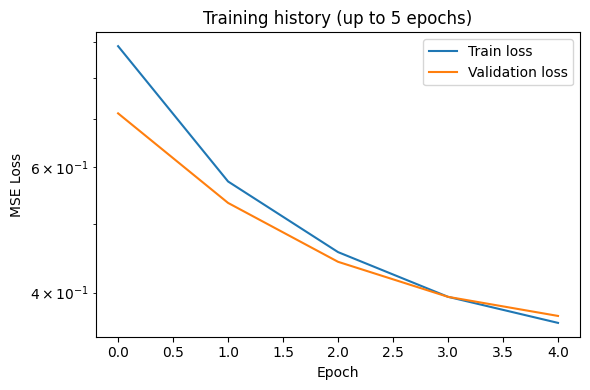


🔍 Evaluating model after 5 epochs...
Loaded model from: checkpoints\model_epoch_5.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.040161  0.200402  0.082585  0.648093

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000001   0.001132   0.000764   0.926497
Linear Velocity   0.000379   0.019458   0.014932   0.464365
         Angles   0.000130   0.011421   0.008538   0.887827
  Angular Rates   0.160133   0.400167   0.306107   0.313685
📊 Logged metrics: Epoch 5 | MSE = 4.016093e-02, R2 = 0.648093

🟢 Training up to 10 / 100 epochs...

Epoch 1/5
50/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3478 
Epoch 1: val_loss improved from None to 0.35631, saving model to checkpoints/best_model_until_10.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3449 - val_loss: 0.3563 - learning_rate: 0.0010
Epoch 2/5
56/93 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 0.3323
Epoch 2: val_loss improved from 0.35631 

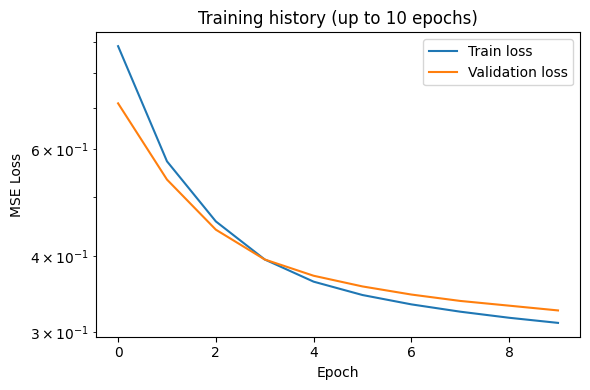


🔍 Evaluating model after 10 epochs...
Loaded model from: checkpoints\model_epoch_10.keras

--- Overall Test Metrics ---
       MSE      RMSE       MAE        R2
0  0.03756  0.193805  0.080117  0.688908

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000001   0.000822   0.000554   0.963394
Linear Velocity   0.000345   0.018582   0.014290   0.493362
         Angles   0.000065   0.008079   0.005944   0.945933
  Angular Rates   0.149830   0.387079   0.299682   0.352945
📊 Logged metrics: Epoch 10 | MSE = 3.756037e-02, R2 = 0.688908

🟢 Training up to 15 / 100 epochs...

Epoch 1/5
59/93 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 0.3175
Epoch 1: val_loss improved from None to 0.32048, saving model to checkpoints/best_model_until_15.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3052 - val_loss: 0.3205 - learning_rate: 0.0010
Epoch 2/5
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 0.3091
Epoch 2: val_loss improved from 0.3204

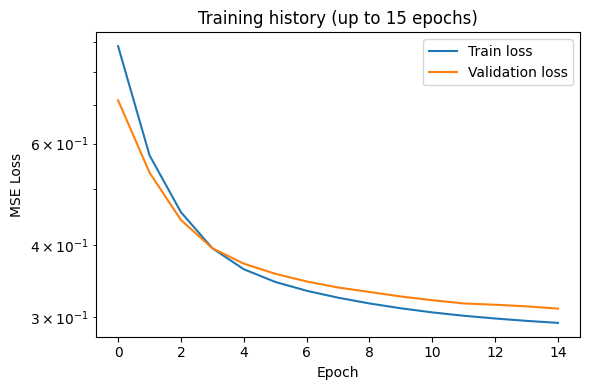


🔍 Evaluating model after 15 epochs...
Loaded model from: checkpoints\model_epoch_15.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE       R2
0  0.037298  0.193127  0.079464  0.69986

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000655   0.000445   0.975386
Linear Velocity   0.000338   0.018393   0.014143   0.501449
         Angles   0.000046   0.006807   0.004971   0.962931
  Angular Rates   0.148808   0.385756   0.298296   0.359673
📊 Logged metrics: Epoch 15 | MSE = 3.729817e-02, R2 = 0.699860

🟢 Training up to 20 / 100 epochs...

Epoch 1/5
51/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2892 
Epoch 1: val_loss improved from None to 0.30927, saving model to checkpoints/best_model_until_20.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2906 - val_loss: 0.3093 - learning_rate: 0.0010
Epoch 2/5
48/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2875 
Epoch 2: val_loss improved from 0.30927 

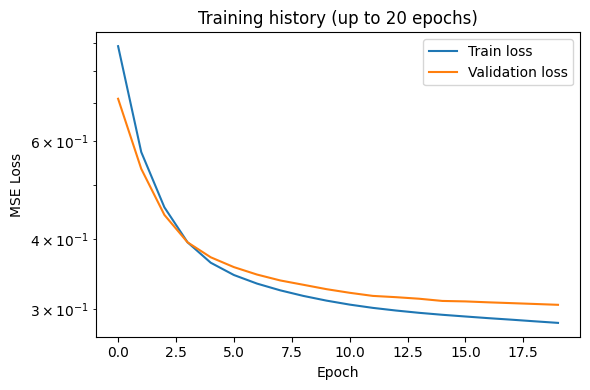


🔍 Evaluating model after 20 epochs...
Loaded model from: checkpoints\model_epoch_20.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.036883  0.192049  0.078758  0.707241

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000585   0.000404   0.978963
Linear Velocity   0.000337   0.018356   0.014173   0.507518
         Angles   0.000041   0.006432   0.004699   0.967528
  Angular Rates   0.147152   0.383605   0.295754   0.374955
📊 Logged metrics: Epoch 20 | MSE = 3.688277e-02, R2 = 0.707241

🟢 Training up to 25 / 100 epochs...

Epoch 1/5
47/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2812 
Epoch 1: val_loss improved from None to 0.30266, saving model to checkpoints/best_model_until_25.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2811 - val_loss: 0.3027 - learning_rate: 0.0010
Epoch 2/5
55/93 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 0.2805
Epoch 2: val_loss improved from 0.302

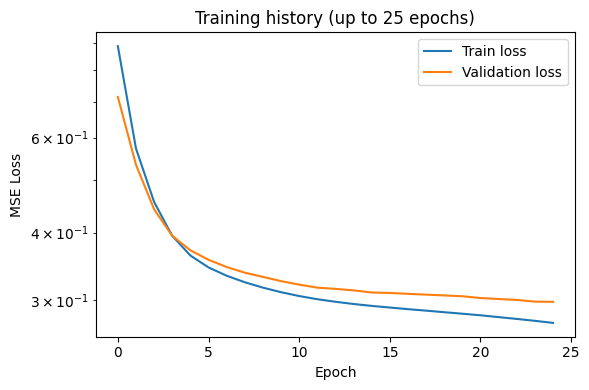


🔍 Evaluating model after 25 epochs...
Loaded model from: checkpoints\model_epoch_25.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.036395  0.190774  0.077801  0.715181

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000549   0.000390   0.979871
Linear Velocity   0.000332   0.018233   0.014082   0.517443
         Angles   0.000040   0.006305   0.004570   0.969637
  Angular Rates   0.145207   0.381060   0.292161   0.393773
📊 Logged metrics: Epoch 25 | MSE = 3.639489e-02, R2 = 0.715181

🟢 Training up to 30 / 100 epochs...

Epoch 1/5
47/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2623 
Epoch 1: val_loss improved from None to 0.29625, saving model to checkpoints/best_model_until_30.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2697 - val_loss: 0.2963 - learning_rate: 0.0010
Epoch 2/5
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2772
Epoch 2: val_loss improved from 0.29625

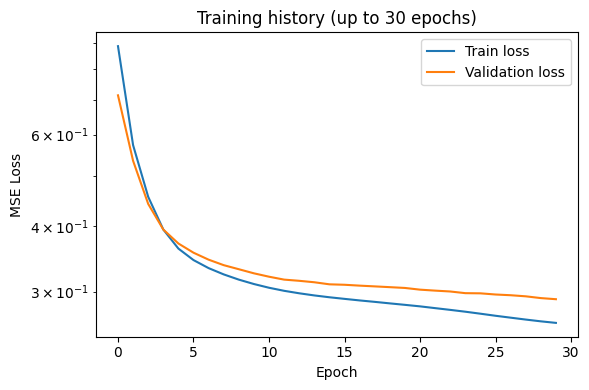


🔍 Evaluating model after 30 epochs...
Loaded model from: checkpoints\model_epoch_30.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.035419  0.188199  0.076522  0.724859

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000522   0.000375   0.979321
Linear Velocity   0.000328   0.018117   0.013990   0.531410
         Angles   0.000034   0.005862   0.004316   0.973539
  Angular Rates   0.141312   0.375916   0.287406   0.415168
📊 Logged metrics: Epoch 30 | MSE = 3.541884e-02, R2 = 0.724859

🟢 Training up to 35 / 100 epochs...

Epoch 1/5
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 0.2594
Epoch 1: val_loss improved from None to 0.28896, saving model to checkpoints/best_model_until_35.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2597 - val_loss: 0.2890 - learning_rate: 0.0010
Epoch 2/5
59/93 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 0.2617
Epoch 2: val_loss improved from 0.28

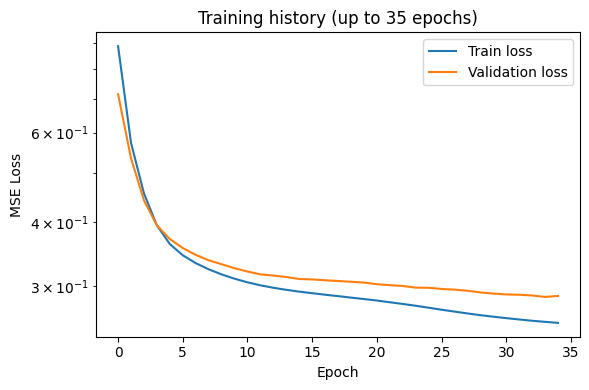


🔍 Evaluating model after 35 epochs...
Loaded model from: checkpoints\model_epoch_35.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.034925  0.186883  0.076019  0.729679

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000517   0.000371   0.978872
Linear Velocity   0.000324   0.017988   0.013916   0.541318
         Angles   0.000031   0.005585   0.004165   0.975679
  Angular Rates   0.139346   0.373291   0.285625   0.422848
📊 Logged metrics: Epoch 35 | MSE = 3.492537e-02, R2 = 0.729679

🟢 Training up to 40 / 100 epochs...

Epoch 1/5
59/93 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 0.2522
Epoch 1: val_loss improved from None to 0.28584, saving model to checkpoints/best_model_until_40.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2532 - val_loss: 0.2858 - learning_rate: 0.0010
Epoch 2/5
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 0.2746
Epoch 2: val_loss did not improve fr

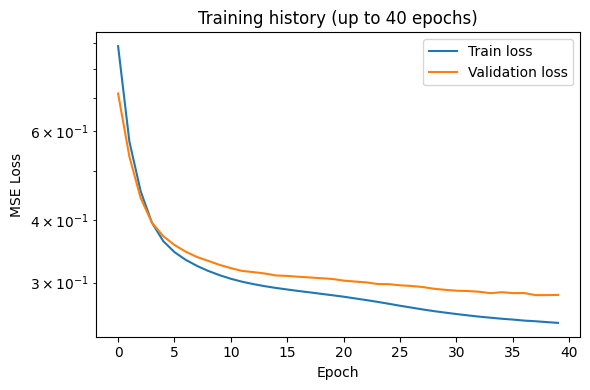


🔍 Evaluating model after 40 epochs...
Loaded model from: checkpoints\model_epoch_40.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.034628  0.186087  0.075593  0.733834

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000503   0.000363   0.978636
Linear Velocity   0.000322   0.017955   0.013849   0.549183
         Angles   0.000029   0.005382   0.004019   0.977313
  Angular Rates   0.138162   0.371702   0.284144   0.430203
📊 Logged metrics: Epoch 40 | MSE = 3.462845e-02, R2 = 0.733834

🟢 Training up to 45 / 100 epochs...

Epoch 1/5
56/93 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 0.2413
Epoch 1: val_loss improved from None to 0.28156, saving model to checkpoints/best_model_until_45.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2487 - val_loss: 0.2816 - learning_rate: 0.0010
Epoch 2/5
60/93 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 0.2398
Epoch 2: val_loss did not improve fr

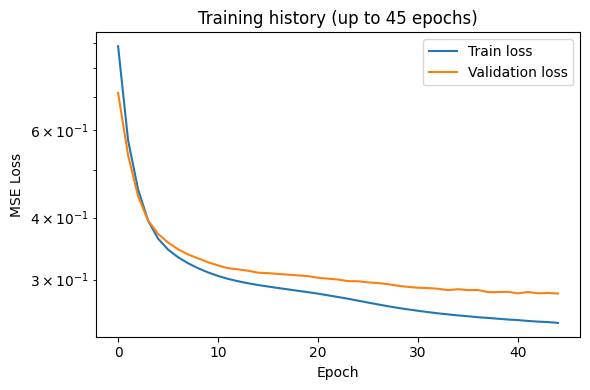


🔍 Evaluating model after 45 epochs...
Loaded model from: checkpoints\model_epoch_45.keras

--- Overall Test Metrics ---
        MSE      RMSE      MAE        R2
0  0.034009  0.184415  0.07517  0.736547

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000498   0.000357   0.978808
Linear Velocity   0.000320   0.017897   0.013828   0.553143
         Angles   0.000029   0.005401   0.004044   0.977208
  Angular Rates   0.135687   0.368357   0.282452   0.437028
📊 Logged metrics: Epoch 45 | MSE = 3.400908e-02, R2 = 0.736547

🟢 Training up to 50 / 100 epochs...

Epoch 1/5
58/93 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 0.2384
Epoch 1: val_loss improved from None to 0.28070, saving model to checkpoints/best_model_until_50.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2448 - val_loss: 0.2807 - learning_rate: 0.0010
Epoch 2/5
60/93 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 0.2519
Epoch 2: val_loss improved from 0.2807

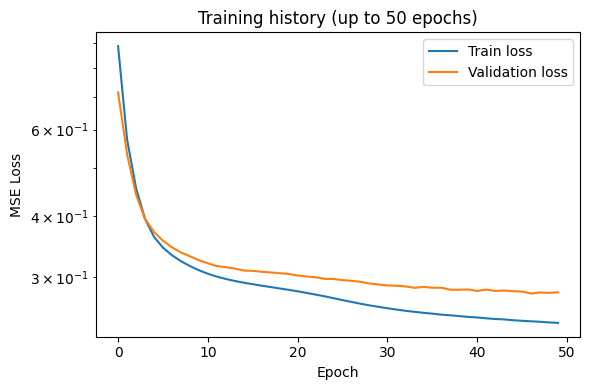


🔍 Evaluating model after 50 epochs...
Loaded model from: checkpoints\model_epoch_50.keras

--- Overall Test Metrics ---
       MSE      RMSE       MAE        R2
0  0.03356  0.183193  0.074602  0.739218

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000481   0.000345   0.979469
Linear Velocity   0.000318   0.017846   0.013753   0.556400
         Angles   0.000029   0.005405   0.004052   0.977145
  Angular Rates   0.133891   0.365911   0.280258   0.443857
📊 Logged metrics: Epoch 50 | MSE = 3.355968e-02, R2 = 0.739218

🟢 Training up to 55 / 100 epochs...

Epoch 1/5
60/93 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 0.2522
Epoch 1: val_loss improved from None to 0.27849, saving model to checkpoints/best_model_until_55.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2420 - val_loss: 0.2785 - learning_rate: 0.0010
Epoch 2/5
62/93 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 0.2318
Epoch 2: val_loss improved from 0.2784

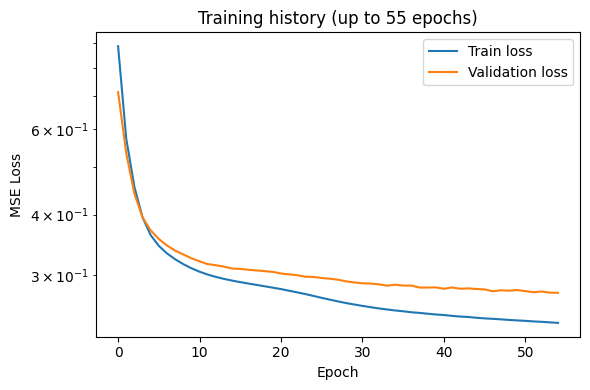


🔍 Evaluating model after 55 epochs...
Loaded model from: checkpoints\model_epoch_55.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.033363  0.182655  0.074579  0.740798

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000470   0.000338   0.980207
Linear Velocity   0.000318   0.017828   0.013738   0.560205
         Angles   0.000029   0.005343   0.004022   0.977484
  Angular Rates   0.133105   0.364836   0.280218   0.445297
📊 Logged metrics: Epoch 55 | MSE = 3.336289e-02, R2 = 0.740798

🟢 Training up to 60 / 100 epochs...

Epoch 1/5
53/93 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 0.2357
Epoch 1: val_loss improved from None to 0.27719, saving model to checkpoints/best_model_until_60.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2392 - val_loss: 0.2772 - learning_rate: 0.0010
Epoch 2/5
61/93 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 0.2270
Epoch 2: val_loss did not improve fr

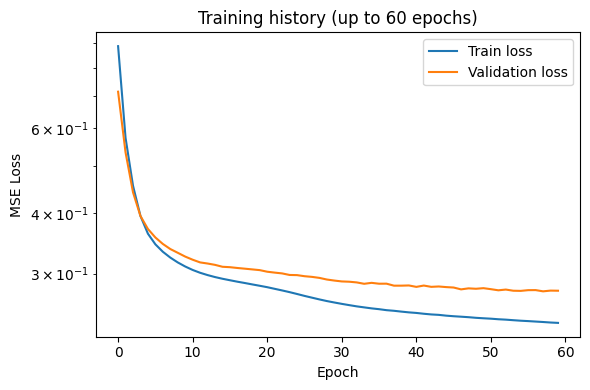


🔍 Evaluating model after 60 epochs...
Loaded model from: checkpoints\model_epoch_60.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.032892  0.181361  0.074175  0.743102

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000473   0.000340   0.980676
Linear Velocity   0.000315   0.017753   0.013684   0.561621
         Angles   0.000027   0.005198   0.003914   0.978340
  Angular Rates   0.131225   0.362250   0.278761   0.451771
📊 Logged metrics: Epoch 60 | MSE = 3.289189e-02, R2 = 0.743102

🟢 Training up to 65 / 100 epochs...

Epoch 1/5
59/93 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 0.2381
Epoch 1: val_loss improved from None to 0.27460, saving model to checkpoints/best_model_until_65.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2365 - val_loss: 0.2746 - learning_rate: 0.0010
Epoch 2/5
58/93 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 0.2288
Epoch 2: val_loss did not improve fr

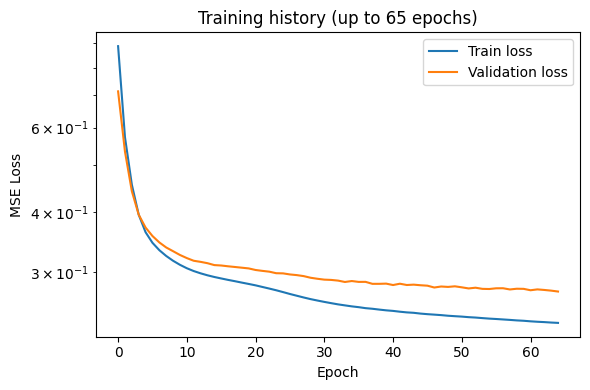


🔍 Evaluating model after 65 epochs...
Loaded model from: checkpoints\model_epoch_65.keras

--- Overall Test Metrics ---
        MSE      RMSE     MAE        R2
0  0.032553  0.180423  0.0738  0.744391

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000452   0.000328   0.981462
Linear Velocity   0.000319   0.017873   0.013735   0.558594
         Angles   0.000026   0.005120   0.003828   0.979051
  Angular Rates   0.129865   0.360367   0.277309   0.458457
📊 Logged metrics: Epoch 65 | MSE = 3.255262e-02, R2 = 0.744391

🟢 Training up to 70 / 100 epochs...

Epoch 1/5
58/93 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 0.2285
Epoch 1: val_loss improved from None to 0.27379, saving model to checkpoints/best_model_until_70.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2342 - val_loss: 0.2738 - learning_rate: 0.0010
Epoch 2/5
64/93 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 0.2335
Epoch 2: val_loss improved from 0.27379 

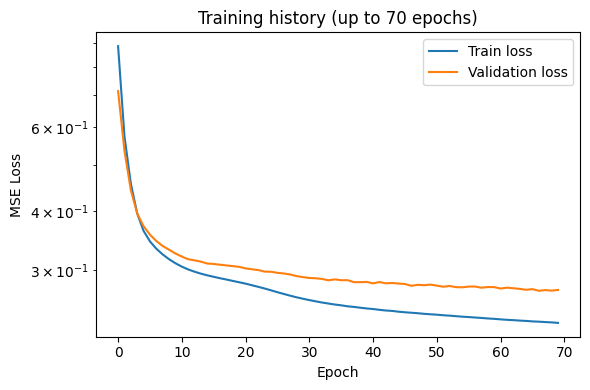


🔍 Evaluating model after 70 epochs...
Loaded model from: checkpoints\model_epoch_70.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE      R2
0  0.032186  0.179404  0.073596  0.7457

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000446   0.000318   0.982773
Linear Velocity   0.000315   0.017747   0.013641   0.560489
         Angles   0.000027   0.005202   0.003938   0.978441
  Angular Rates   0.128402   0.358332   0.276485   0.461098
📊 Logged metrics: Epoch 70 | MSE = 3.218597e-02, R2 = 0.745700

🟢 Training up to 75 / 100 epochs...

Epoch 1/5
56/93 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 0.2372
Epoch 1: val_loss improved from None to 0.27120, saving model to checkpoints/best_model_until_75.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2323 - val_loss: 0.2712 - learning_rate: 0.0010
Epoch 2/5
62/93 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - loss: 0.2256
Epoch 2: val_loss improved from 0.27120 

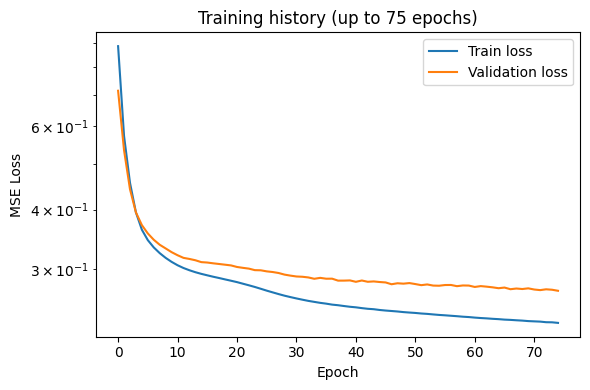


🔍 Evaluating model after 75 epochs...
Loaded model from: checkpoints\model_epoch_75.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.031768  0.178235  0.073146  0.748782

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000439   0.000316   0.983853
Linear Velocity   0.000313   0.017685   0.013553   0.563634
         Angles   0.000027   0.005188   0.003917   0.978448
  Angular Rates   0.126732   0.355994   0.274798   0.469195
📊 Logged metrics: Epoch 75 | MSE = 3.176788e-02, R2 = 0.748782

🟢 Training up to 80 / 100 epochs...

Epoch 1/5
48/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2283 
Epoch 1: val_loss improved from None to 0.26915, saving model to checkpoints/best_model_until_80.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2302 - val_loss: 0.2692 - learning_rate: 0.0010
Epoch 2/5
62/93 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - loss: 0.2389
Epoch 2: val_loss improved from 0.269

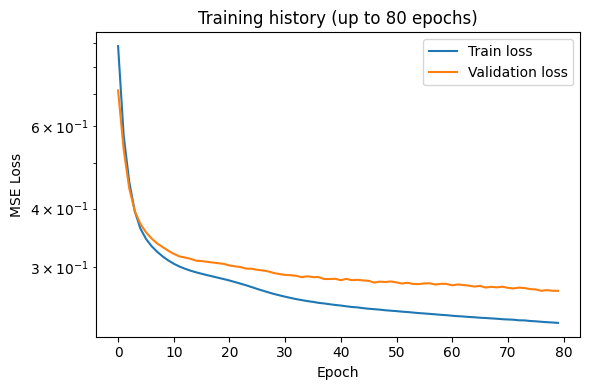


🔍 Evaluating model after 80 epochs...
Loaded model from: checkpoints\model_epoch_80.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.031463  0.177379  0.072834  0.750819

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000416   0.000305   0.985200
Linear Velocity   0.000313   0.017692   0.013519   0.567545
         Angles   0.000026   0.005099   0.003811   0.979152
  Angular Rates   0.125515   0.354280   0.273699   0.471379
📊 Logged metrics: Epoch 80 | MSE = 3.146342e-02, R2 = 0.750819

🟢 Training up to 85 / 100 epochs...

Epoch 1/5
56/93 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 0.2285
Epoch 1: val_loss improved from None to 0.26731, saving model to checkpoints/best_model_until_85.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2281 - val_loss: 0.2673 - learning_rate: 0.0010
Epoch 2/5
58/93 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 0.2256
Epoch 2: val_loss did not improve fr

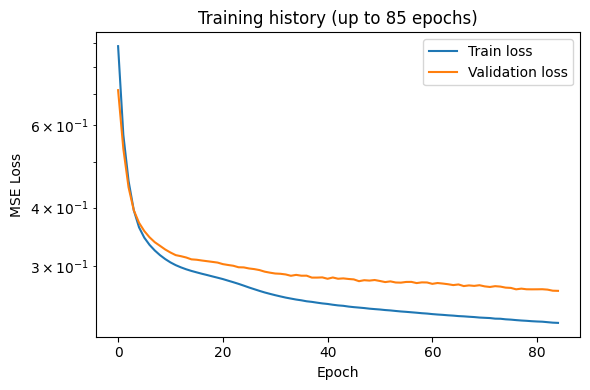


🔍 Evaluating model after 85 epochs...
Loaded model from: checkpoints\model_epoch_85.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.030931  0.175871  0.072357  0.752723

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000414   0.000300   0.985693
Linear Velocity   0.000307   0.017516   0.013385   0.568277
         Angles   0.000026   0.005112   0.003822   0.979049
  Angular Rates   0.123390   0.351269   0.271918   0.477872
📊 Logged metrics: Epoch 85 | MSE = 3.093069e-02, R2 = 0.752723

🟢 Training up to 90 / 100 epochs...

Epoch 1/5
55/93 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 0.2271
Epoch 1: val_loss improved from None to 0.26371, saving model to checkpoints/best_model_until_90.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2259 - val_loss: 0.2637 - learning_rate: 0.0010
Epoch 2/5
62/93 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 0.2238
Epoch 2: val_loss did not improve fr

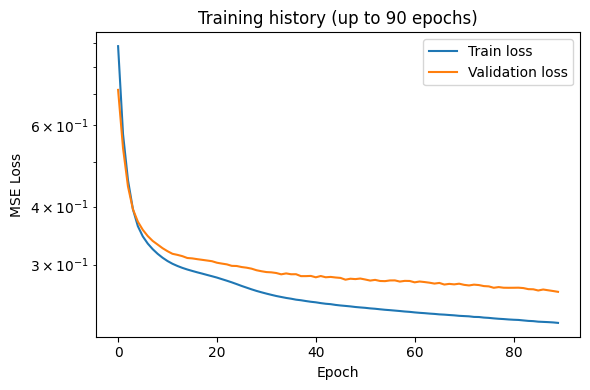


🔍 Evaluating model after 90 epochs...
Loaded model from: checkpoints\model_epoch_90.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE       R2
0  0.031076  0.176285  0.072531  0.75262

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000406   0.000294   0.986482
Linear Velocity   0.000302   0.017377   0.013300   0.572093
         Angles   0.000026   0.005142   0.003849   0.978819
  Angular Rates   0.123977   0.352104   0.272682   0.473084
📊 Logged metrics: Epoch 90 | MSE = 3.107639e-02, R2 = 0.752620

🟢 Training up to 95 / 100 epochs...

Epoch 1/5
48/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2187 
Epoch 1: val_loss improved from None to 0.26208, saving model to checkpoints/best_model_until_95.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2243 - val_loss: 0.2621 - learning_rate: 0.0010
Epoch 2/5
63/93 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - loss: 0.2168
Epoch 2: val_loss improved from 0.26208

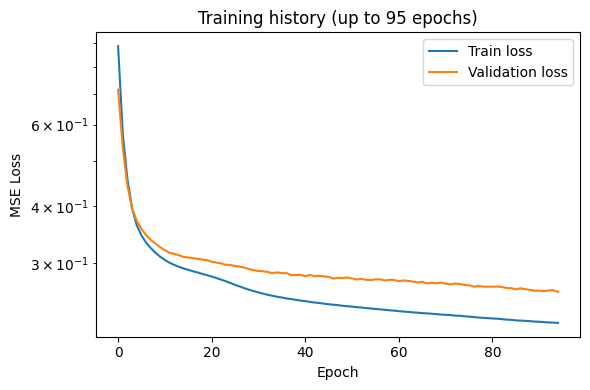


🔍 Evaluating model after 95 epochs...
Loaded model from: checkpoints\model_epoch_95.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE        R2
0  0.030932  0.175876  0.072382  0.754705

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000408   0.000298   0.986606
Linear Velocity   0.000299   0.017297   0.013237   0.577189
         Angles   0.000027   0.005171   0.003850   0.978790
  Angular Rates   0.123403   0.351288   0.272141   0.476235
📊 Logged metrics: Epoch 95 | MSE = 3.093231e-02, R2 = 0.754705

🟢 Training up to 100 / 100 epochs...

Epoch 1/5
58/93 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 0.2244
Epoch 1: val_loss improved from None to 0.26030, saving model to checkpoints/best_model_until_100.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2229 - val_loss: 0.2603 - learning_rate: 0.0010
Epoch 2/5
38/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2170 
Epoch 2: val_loss improved from 0.2

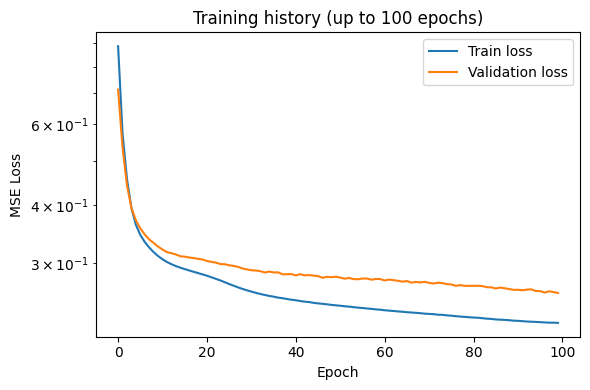


🔍 Evaluating model after 100 epochs...
Loaded model from: checkpoints\model_epoch_100.keras

--- Overall Test Metrics ---
        MSE    RMSE       MAE        R2
0  0.031046  0.1762  0.072237  0.755011

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000395   0.000287   0.987138
Linear Velocity   0.000298   0.017255   0.013202   0.577842
         Angles   0.000027   0.005149   0.003847   0.978787
  Angular Rates   0.123861   0.351939   0.271611   0.476278
📊 Logged metrics: Epoch 100 | MSE = 3.104642e-02, R2 = 0.755011

💾 All experiment parameters and results saved to:
checkpoints\3_no_shuffle.json

📈 Performance summary:
    epochs                         model_path       MSE        R2
0        5    checkpoints\model_epoch_5.keras  0.040161  0.648093
1       10   checkpoints\model_epoch_10.keras  0.037560  0.688908
2       15   checkpoints\model_epoch_15.keras  0.037298  0.699860
3       20   checkpoints\model_epoch_2

In [22]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import joblib
import pandas as pd

# --- Configuration ---
total_epochs = 100
eval_interval = 5    # evaluate every 100 epochs
batch_size = 128
save_dir = "checkpoints"

os.makedirs(save_dir, exist_ok=True)

# --- Global experiment configuration dictionary ---
experiment_params = {
    "dataset_split" : "Training set shuffled",
    "randdom_seed" : random_seed ,
    "model_name": "MLP",
    "learning_rate": 1e-3,
    "batch_size": batch_size,
    "total_epochs": total_epochs,
    "eval_interval": eval_interval,
    "data_file": file_path,
    "model_summary" : layer_sizes,
    "results": []  # will be filled dynamically
    
}

# --- Callbacks ---
def make_callbacks(current_epoch):
    """Create callbacks for the current training chunk."""
    return [
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=20,
            min_lr=1e-6,
            verbose=1
        ),
        ModelCheckpoint(
            filepath=f"{save_dir}/best_model_until_{current_epoch}.keras",
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=False,
            verbose=1
        )
    ]

# --- Save scalers once ---
joblib.dump(sc_in, f"{save_dir}/sc_in.joblib")
joblib.dump(sc_out, f"{save_dir}/sc_out.joblib")

# --- Initialize training record ---
history_all = {'loss': [], 'val_loss': []}

# --- Training and evaluation loop ---
for current_epoch in range(eval_interval, total_epochs + 1, eval_interval):
    print(f"\n🟢 Training up to {current_epoch} / {total_epochs} epochs...\n")

    # Train for eval_interval epochs (continues from current weights)
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=eval_interval,
        batch_size=batch_size,
        verbose=1,
        callbacks=make_callbacks(current_epoch),
        shuffle=True
    )

    # --- Update training history ---
    history_all['loss'].extend(history.history['loss'])
    history_all['val_loss'].extend(history.history['val_loss'])

    # --- Save model manually every eval_interval ---
    model_save_path = os.path.join(save_dir, f"model_epoch_{current_epoch}.keras")
    model.save(model_save_path)
    print(f"💾 Model saved at {model_save_path}")

    # --- Best epoch so far ---
    best_epoch = np.argmin(history_all['val_loss']) + 1
    best_val_loss = np.min(history_all['val_loss'])
    print(f"\n🏆 Best epoch so far: {best_epoch} with val_loss = {best_val_loss:.6f}\n")

    # --- Plot training history ---
    plt.figure(figsize=(6, 4))
    plt.plot(history_all['loss'], label='Train loss')
    plt.plot(history_all['val_loss'], label='Validation loss')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.title(f'Training history (up to {current_epoch} epochs)')
    plt.tight_layout()
    plt.show()

    # --- Evaluate model ---
    print(f"\n🔍 Evaluating model after {current_epoch} epochs...")
    results = test_keras_model_grouped(
        model_path=model_save_path,   # evaluate the just-saved model
        X_test=X_test,
        Y_test=Y_test,
        sc_out=sc_out,
        plot_dim=0
    )

    # --- Extract metrics ---
    mse = float(results["overall"]["MSE"])
    r2 = float(results["overall"]["R2"])

    experiment_params["results"].append({
        "epochs": current_epoch,
        "model_path": model_save_path,
        "MSE": mse,
        "R2": r2
    })

    print(f"📊 Logged metrics: Epoch {current_epoch} | MSE = {mse:.6e}, R2 = {r2:.6f}")

# --- Save the entire experiment dictionary as JSON ---
json_path = os.path.join(save_dir, "3_no_shuffle.json")
with open(json_path, "w") as f:
    json.dump(experiment_params, f, indent=4)

print(f"\n💾 All experiment parameters and results saved to:\n{json_path}")

# --- Optional: show quick summary ---
df_results = pd.DataFrame(experiment_params["results"])
print("\n📈 Performance summary:")
print(df_results)


## Training performance
We can observe that our model conserves a very good capability of abstraction while on the other hand is very performative to learn

Loaded model from: checkpoints\model_epoch_100.keras

--- Overall Test Metrics ---
        MSE      RMSE       MAE       R2
0  0.009141  0.095607  0.038097  0.78589

--- Metrics by Group ---
     Group          MSE       RMSE        MAE        R2    
Linear Position   0.000000   0.000362   0.000224   0.989408
Linear Velocity   0.000145   0.012053   0.008779   0.650362
         Angles   0.000010   0.003165   0.002102   0.984291
  Angular Rates   0.036407   0.190807   0.141284   0.519499


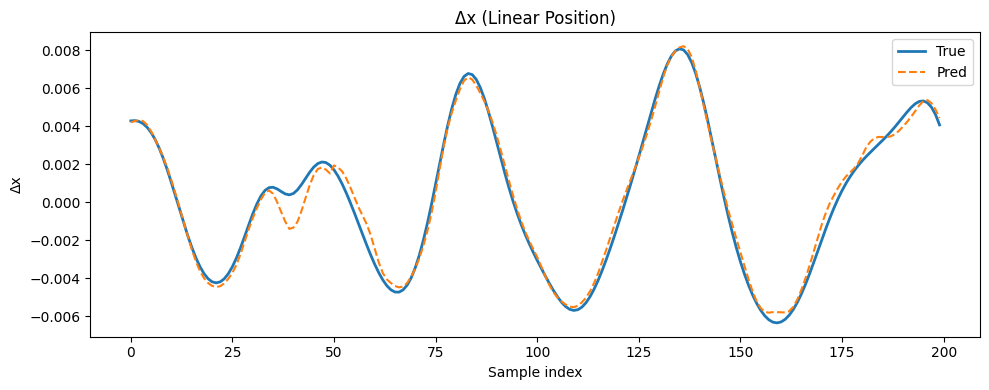

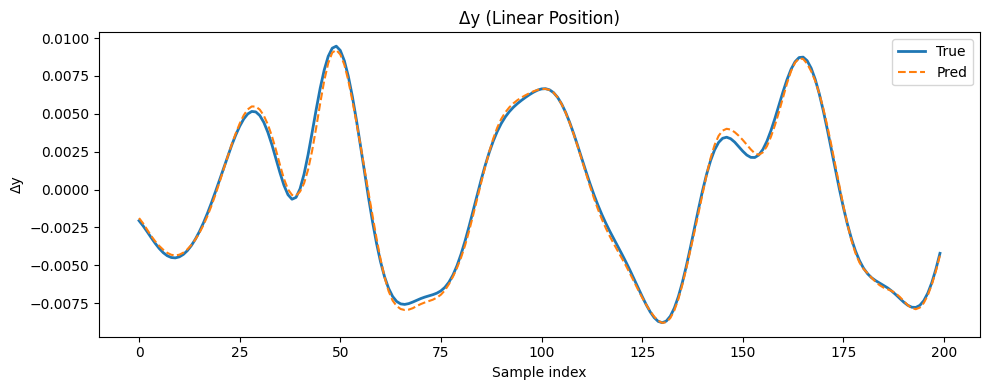

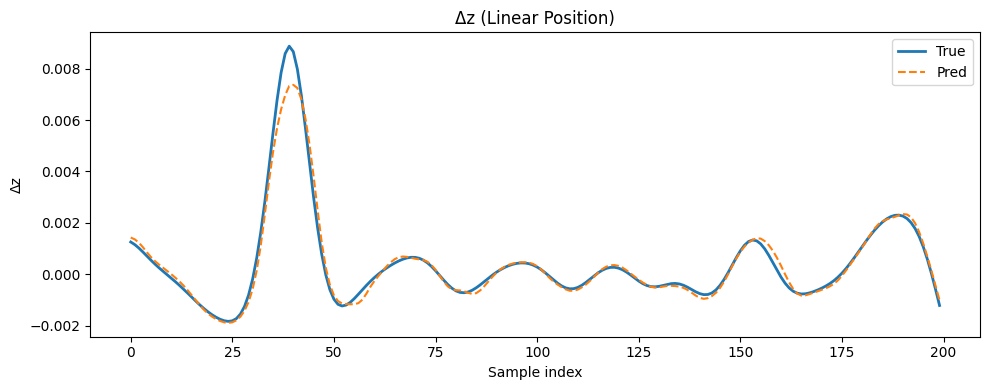

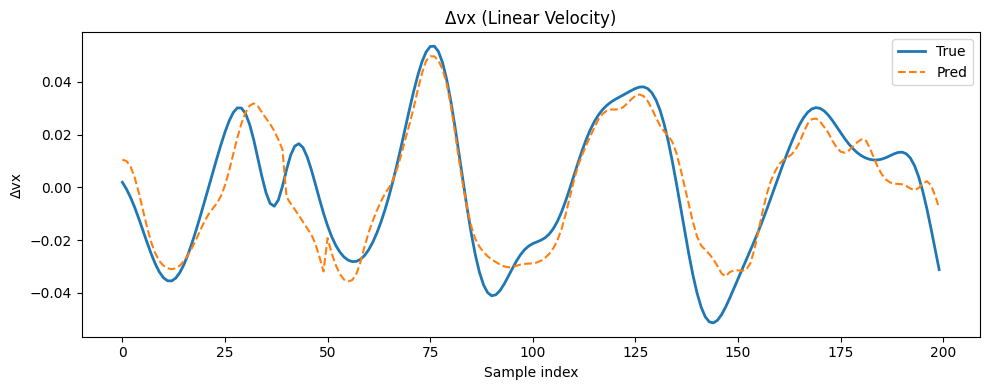

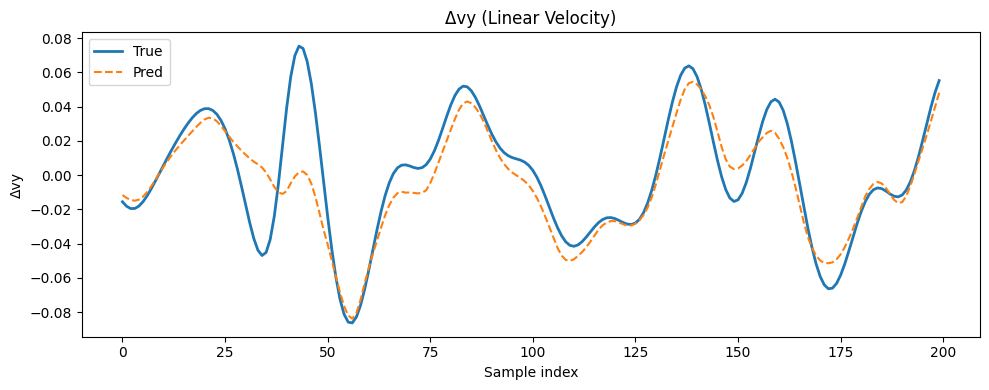

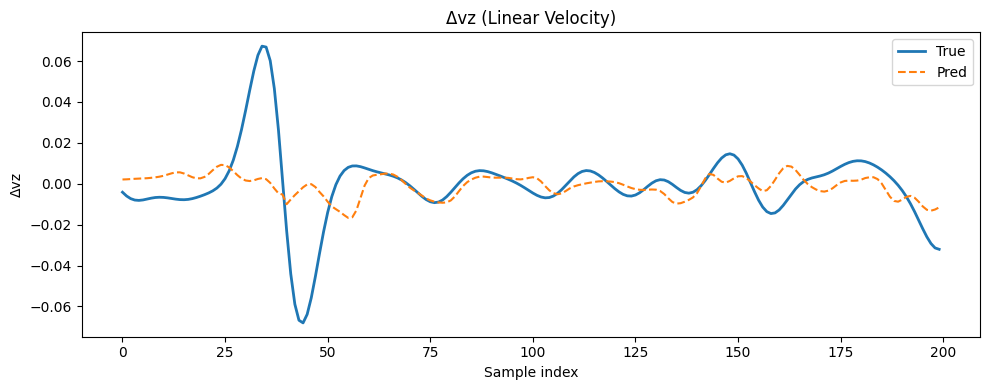

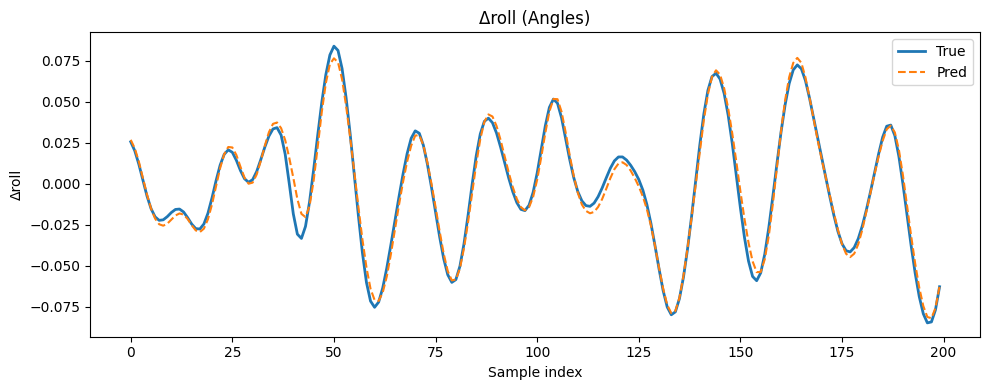

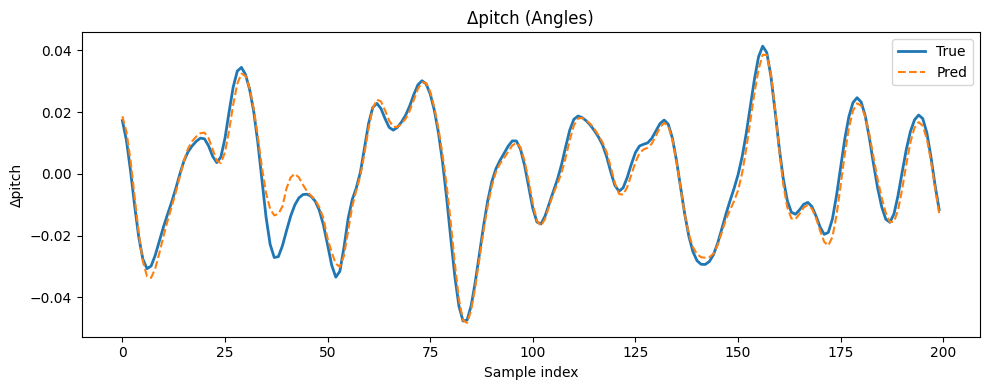

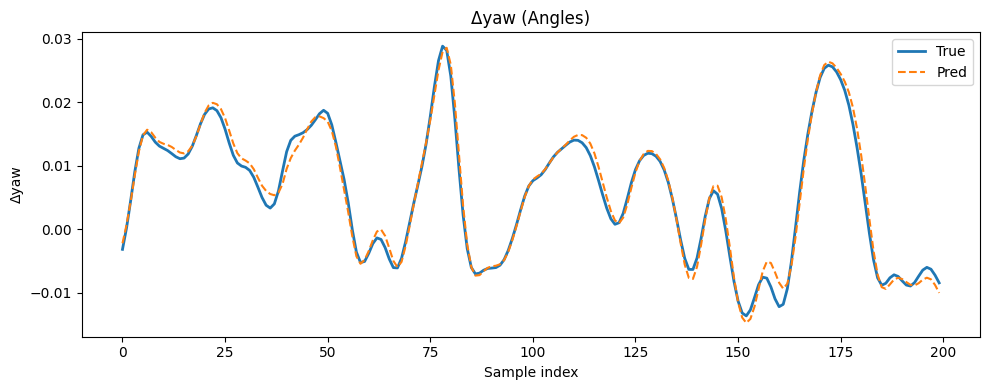

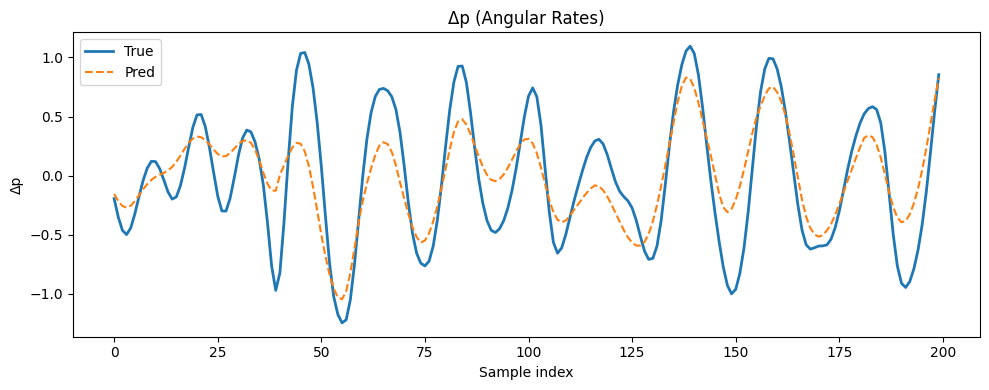

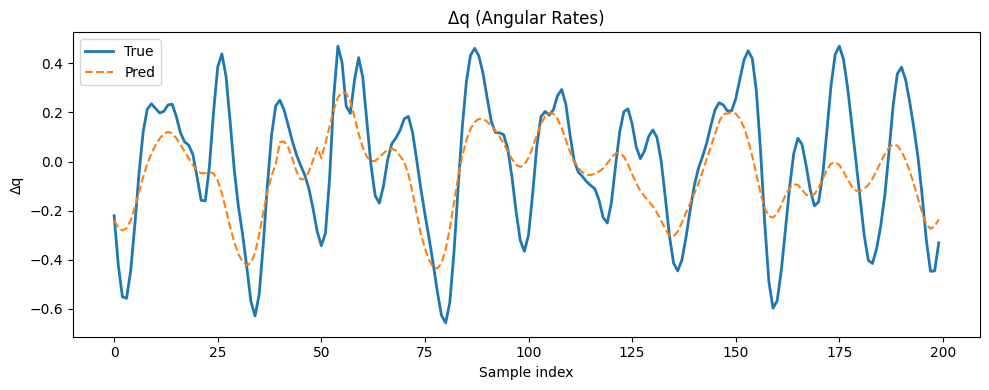

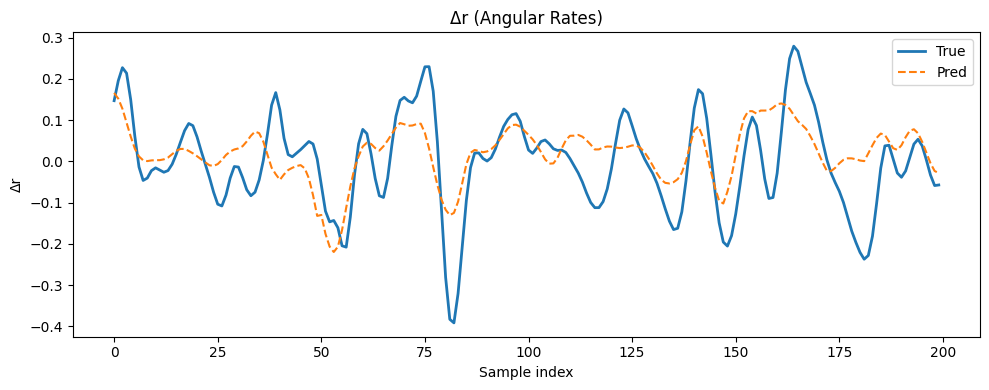

In [18]:
model_path="checkpoints\model_epoch_100.keras"

results3 = test_keras_model_grouped(
    model_path= model_path,
    X_test=X_test,
    Y_test=Y_test,
    sc_out=sc_out,
    plot_dim=12   # number of output dimensions to plot
)

## Testing performances
We have no data left for evaluating a rollout since the test set is composed by shuffled data. Selecting random indices for the training, validation and test set made the net very performative (almost 100%) at understanding the evolution deltaX of the system's dynamics, but makes it impossible to evaluate an open loop rollout on an ordered test set.

Plot limited to first 2.000s (200 samples).


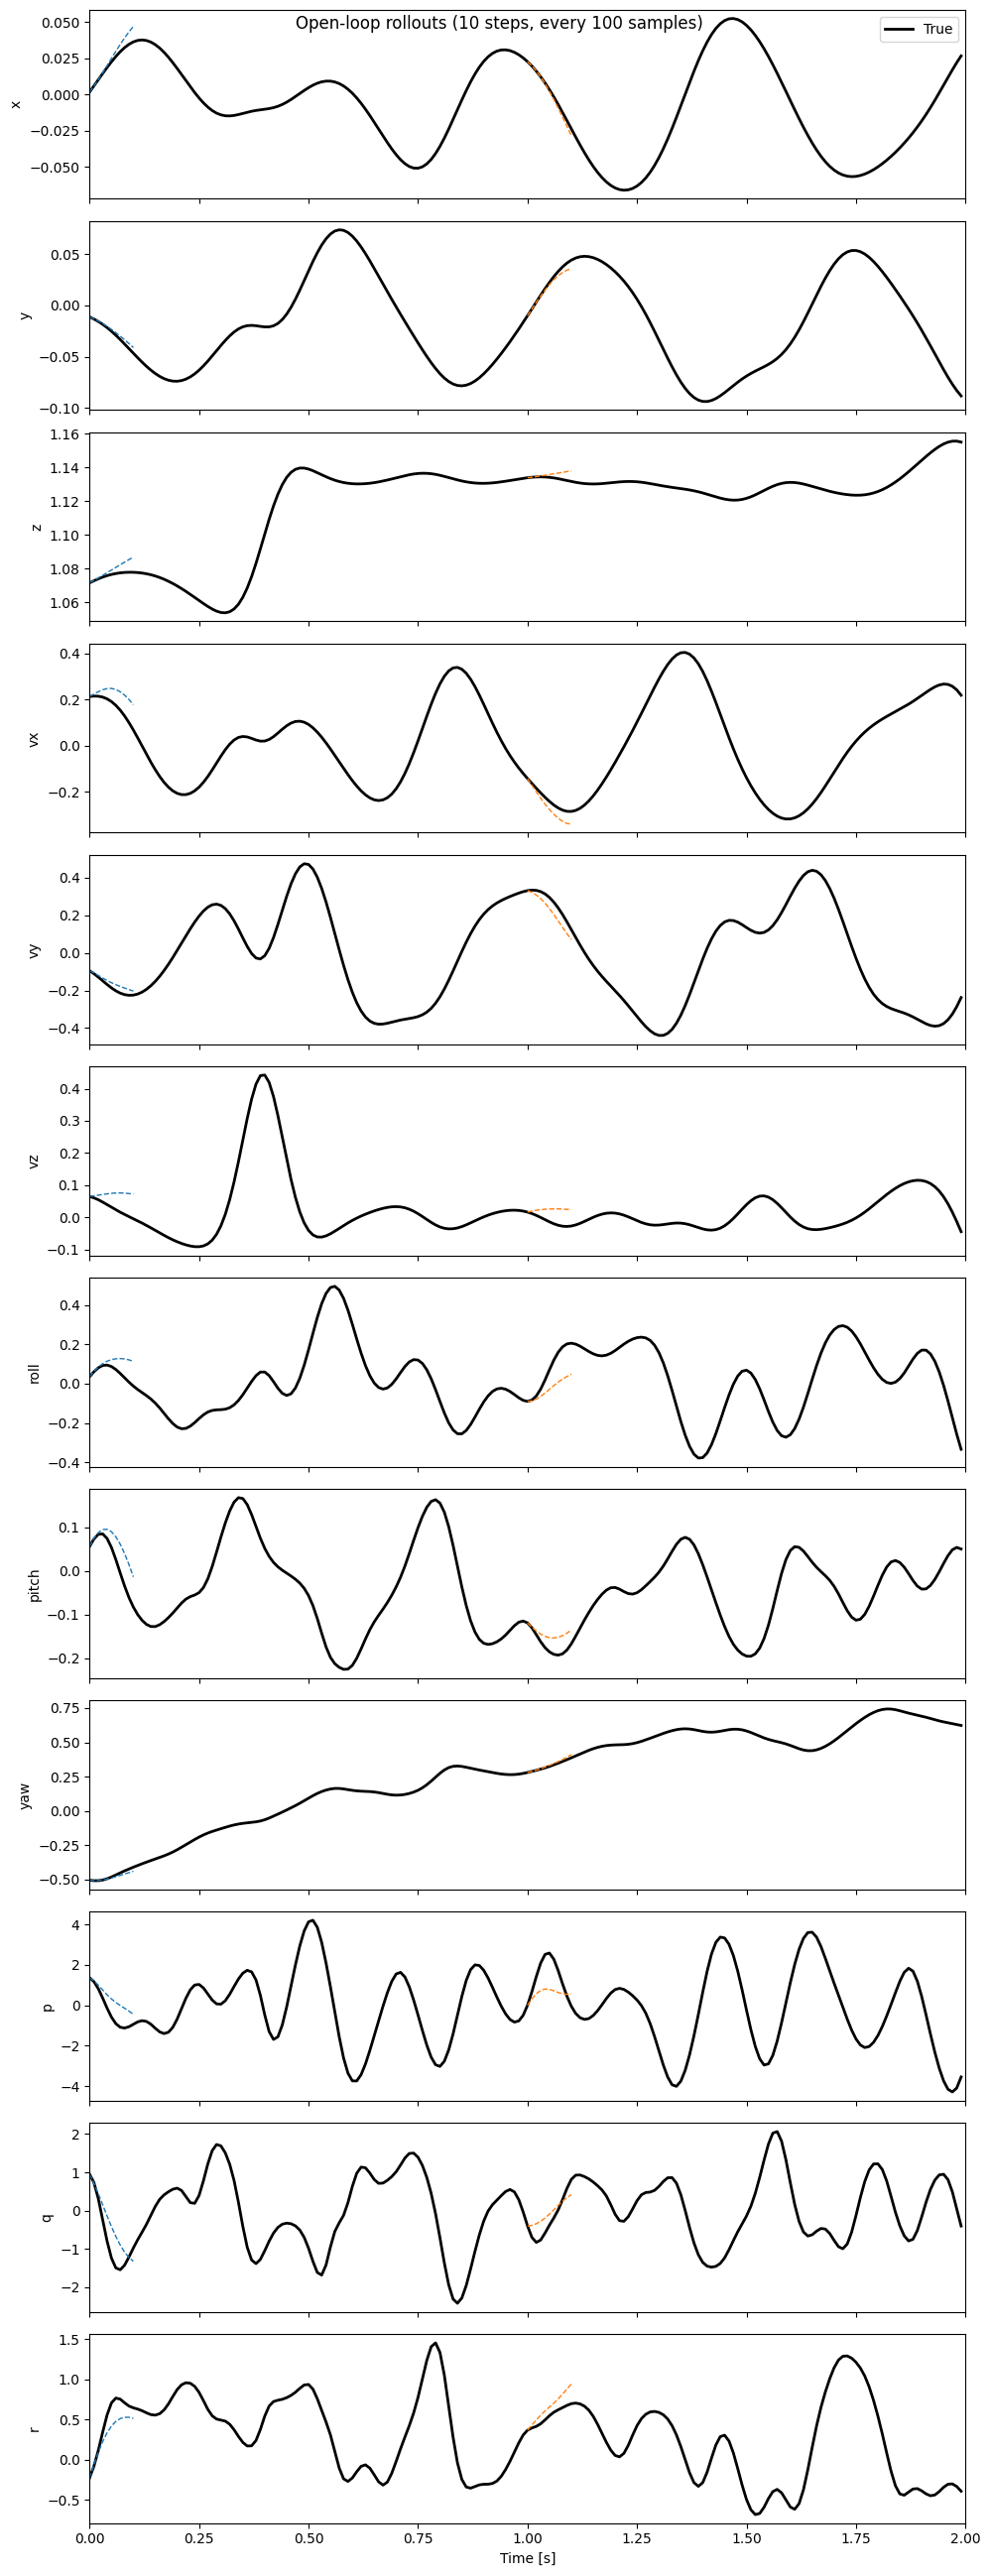


--- Open-loop horizon metrics (physical units) ---
MSE:  4.435235e-02
RMSE: 2.106000e-01
MAE:  1.286549e-01
R2:   -6.943960


In [26]:
def rollout_openloop_model(
    model, X_test, sc_in, sc_out,
    n_x, n_u, dt=0.01, N_pred=5, stride=50,
    state_labels=None, plot_dim=None, max_plot_pts=200,
    t_max=None    # ← max time (in seconds) to display
):
    """
    Open-loop rollout on the TEST set (no shuffling), consistent with training:
    - keeps x in physical units,
    - builds normalized input with sc_in,
    - predicts Δx in normalized units, denormalizes with sc_out,
    - updates x_phys += Δx_phys,
    - optionally limits plots to t_max seconds (x-axis in real time).
    """

    # --- Denormalize test states and inputs ---
    X_phys, U_phys = get_test_states_inputs_physical(X_test, sc_in, n_x)
    N = len(X_phys)

    if state_labels is None:
        state_labels = [f"x{i+1}" for i in range(n_x)]
    if plot_dim is None:
        plot_dim = n_x

    # --- Build time vector ---
    t = np.arange(N) * dt

    # --- Optional limit for plotting only ---
    if t_max is not None:
        max_idx = np.searchsorted(t, t_max)
        X_phys = X_phys[:max_idx]
        U_phys = U_phys[:max_idx]
        t = t[:max_idx]
        N = len(X_phys)
        print(f"Plot limited to first {t_max:.3f}s ({N} samples).")

    # --- Plot true trajectories ---
    fig, axes = plt.subplots(n_x, 1, figsize=(10, 2.2 * n_x), sharex=True)
    if n_x == 1:
        axes = [axes]

    for i in range(n_x):
        axes[i].plot(t, X_phys[:, i], "k-", lw=2, label="True")
        axes[i].set_ylabel(state_labels[i])

    # --- Perform rollouts ---
    for k0 in range(0, N - N_pred, stride):
        x_phys = X_phys[k0].copy()
        traj_pred = [x_phys.copy()]

        for k in range(N_pred):
            if k0 + k >= N:
                break
            u_phys = U_phys[k0 + k]

            # Build normalized input [x,u]
            x_n = transform_cols(sc_in, x_phys.reshape(1, -1), 0).ravel()
            u_n = transform_cols(sc_in, u_phys.reshape(1, -1), n_x).ravel()
            inp_n = np.concatenate([x_n, u_n], axis=0).reshape(1, -1)

            # Predict Δx and update physical state
            delta_x_n = model.predict(inp_n, verbose=0)
            delta_x_phys = delta_x_n * sc_out.scale_ + sc_out.mean_
            x_phys = x_phys + delta_x_phys.ravel()
            traj_pred.append(x_phys.copy())

        traj_pred = np.array(traj_pred)
        t_pred = t[k0 : k0 + len(traj_pred)]

        for i in range(min(plot_dim, n_x)):
            axes[i].plot(
                t_pred[:max_plot_pts],
                traj_pred[:max_plot_pts, i],
                "--", lw=1
            )

    # --- Axis labels, limits, and formatting ---
    axes[-1].set_xlabel("Time [s]")
    for ax in axes:
        if t_max is not None:
            ax.set_xlim(0, t_max)
    axes[0].legend()

    fig.suptitle(f"Open-loop rollouts ({N_pred} steps, every {stride} samples)")
    plt.tight_layout()
    plt.show()

    # --- Metrics computation (unchanged) ---
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    Y_true_list, Y_pred_list = [], []
    for k0 in range(0, N - N_pred, stride):
        x_pred = X_phys[k0].copy()
        for k in range(N_pred):
            if k0 + k >= N:
                break
            u_phys = U_phys[k0 + k]
            x_n = transform_cols(sc_in, x_pred.reshape(1, -1), 0).ravel()
            u_n = transform_cols(sc_in, u_phys.reshape(1, -1), n_x).ravel()
            inp_n = np.concatenate([x_n, u_n], axis=0).reshape(1, -1)
            delta_x_n = model.predict(inp_n, verbose=0)
            delta_x_phys = delta_x_n * sc_out.scale_ + sc_out.mean_
            x_pred = x_pred + delta_x_phys.ravel()
        Y_pred_list.append(x_pred)
        Y_true_list.append(X_phys[k0 + N_pred])

    if Y_true_list:
        Y_true = np.vstack(Y_true_list)
        Y_pred = np.vstack(Y_pred_list)

        mse = mean_squared_error(Y_true, Y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(Y_true, Y_pred)
        r2 = r2_score(Y_true, Y_pred)

        print("\n--- Open-loop horizon metrics (physical units) ---")
        print(f"MSE:  {mse:.6e}")
        print(f"RMSE: {rmse:.6e}")
        print(f"MAE:  {mae:.6e}")
        print(f"R2:   {r2:.6f}")

        return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}
    else:
        print("Not enough samples to compute horizon metrics.")
        return None


n_x = Y_test.shape[1]
n_u = X_test.shape[1] - n_x

metrics = rollout_openloop_model(
    model=load_model(model_path),
    X_test=X_test,
    sc_in=sc_in,
    sc_out=sc_out,
    n_x=n_x,
    n_u=n_u,
    dt=0.01,
    N_pred=10,
    stride=100,
    t_max=2.0,   # <-- plot only first 2 seconds
    state_labels=["x","y","z","vx","vy","vz","roll","pitch","yaw","p","q","r"],
    plot_dim=12
)
